# Introduction to SoS notebook

Bo Peng, Nov. 2016

Script of Scripts ([SoS](http://bopeng.github.io/SOS/)) provides a file format, a workflow engine, as well as environments in which you can compose and execute scripts in multiple languages. This notebook demonstrates how to use SoS as a notebook tool using [Jupyter](http://jupyter.org/).

The newest version of this tutorial will always be available at the public SoS server.

## Starting SoS notebook

If you have Python 3 (>=3.4.0) installed, installation of SoS can usually be done using command

```
% pip3 install sos
```
or

```
% pip install sos
```
depending on your system configuration. This command will also install Jupyter notebook and the SoS kernel for Jupyter.

After installation you can check if you have everything ready by running command

In [1]:
# you can run any shell command with a leading !
!jupyter kernelspec list

Available kernels:
  python3    /Users/bpeng1/bin/anaconda/lib/python3.5/site-packages/ipykernel/resources
  ir         /Users/bpeng1/Library/Jupyter/kernels/ir
  sos        /Users/bpeng1/bin/anaconda/share/jupyter/kernels/sos


If the command runs and outputs a kernel named `sos`, you can start Jupyter notebook using command

```
% jupyter notebook
```
and select `SoS` when you start a new notebook. Note that you will need to install the [IRkernel](https://github.com/IRkernel/IRkernel) if you would like to use R in SoS notebooks.

SoS provides a public Jupyter server that runs a Docker image with SoS, Python, R and many related tools. You can use SoS with this server directly without a local installation of SoS.

## String interpolation

SoS is based on Python 3 syntax so you can execute any valid Python expression and statements in a SoS notebook. For example, you can import module, define and run functions in a cell

In [1]:
import random
def dice(name):
    print('{} throws {}'.format(name, random.randint(1, 6)))
dice('Jack')
dice('Jill')


Jack throws 2
Jill throws 1


To make it easier to compose scripts in different languages, SoS treats all strings as format strings that can be **interpolated**. Using a default sigil (symbols to enclose expressions) of `${ }`, you can use arbitrary Python expressions in a string. this example uses the **%preview** magic of SoS kernel to display the value of SoS variables

In [7]:
%preview ref_genome 
resource   = '~/resources'
ref_genome = '${resource}/ref_genome/hg19'

## %preview ref_genome

>>> ref_genome:

'~/resources/ref_genome/hg19'

You can use any Python expression for string interpolation, and the result can be formated using format (:) and convertion (!) specifications. For example, the "!," converter joins items in a sequence by " ,".

In [6]:
samples    = ['sampleA', 'sampleB', 'sampleC']
print('${len(samples)} samples with names ${samples!,}.')

3 samples with names sampleA, sampleB, sampleC.


## Compose and execute scripts

SoS relies on string interpolation to compose scripts that can be executed by other interpreters. For example, the following creates a bash scripts and executes it. The "`e`" converter performs "`os.path.expanduser`", which is frequently required for user-specified path.

In [8]:
run:
    echo ${ref_genome!e}

/Users/bpeng1/resources/ref_genome/hg19


The "`run`" statement is a SoS **action** written in a special script style. It is equivalent to 

In [9]:
run("""
echo ${ref_genome!e}
""")

/Users/bpeng1/resources/ref_genome/hg19


The script style is more readable than function style and is highly recommended. 

## Using other languages


There are two ways to use other languages in SoS.

1. **Create scripts and use SoS to execute them** as you have seen for cells that start with `run:` and `python:`. This method requires the availability of the underlying interpreter (`bash`, `python`, `R` etc) but not corresponding Jupyter kernels. The scripts must be complete in this case.

2. **Start separate kernels using SoS magics `%with` and `%use` **. The `%with` magic allows you to execute a cell in a separate kernel, and `%use` magic allows you to switch to another kenel until you switch back. The scripts and commands will be executed in the kernels interactively and have access to variables in previous runs.

In [7]:
%with R
numbers = rnorm(5)
numbers

[1]  1.9440581  0.2689543  0.7551632 -1.4833636  0.4997274

SoS will switch back to the SoS kernel after the evaluation. It is also worth noting that the communication is one-directional in that whereas the scripts can be created using SoS variables, SoS does not collect any result from another kernel (to which SoS knows nothing). For example, the `numbers` variable in the IR kernel is unknown to SoS:

In [8]:
numbers

Failed to process statement 'numbers': name 'numbers' is not defined

Now, if you have a long script that you would like to debug line by line, you can switch to another kernel and switch back until you are done:

In [9]:
%use R

In [10]:
numbers

[1]  1.9440581  0.2689543  0.7551632 -1.4833636  0.4997274

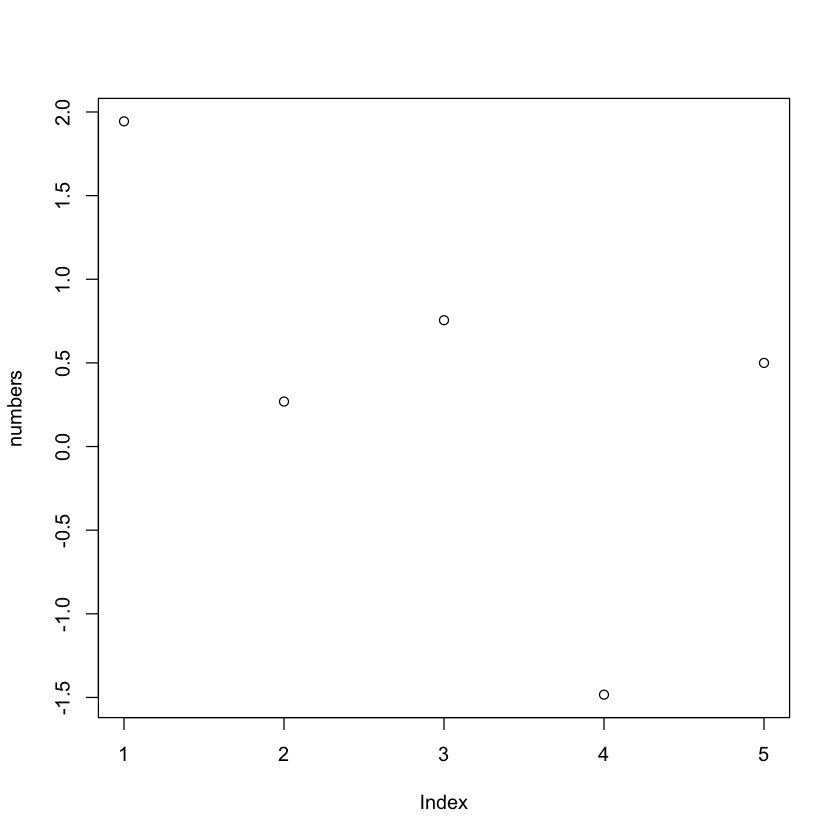

In [11]:
plot(numbers)

In [12]:
%use sos
# this magic switch the notebook back to SoS kernel

## SoS steps

In addition to variable definitions and execution of scripts, notebook cells can contain arbitrary SoS statements and steps. This section demonstrates some of the features that are most useful for interactive use. Please refer to the [SoS documentation](https://github.com/BoPeng/SOS/wiki/Documentation) for a complete reference.

First, you can specify one or more output files in each step. Other than using variables `_output` and `output` for the script, SOS can preview the output files for most file types.

null device 
          1 


## -- Preview output --

input: 
output: test.jpg


> test.jpg (24.5 KiB)

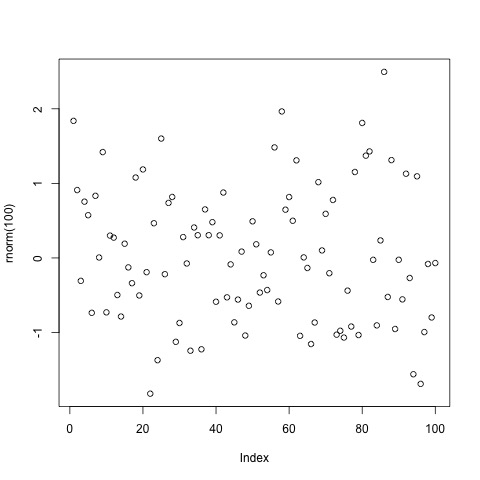

In [13]:
output: 'test.jpg'
R:
    jpeg('${output}')
    plot(rnorm(100))
    dev.off()

The `%set` magic can be used to set SoS options such as verbosity (`-v`), tracribe (`-t`), prepare mode (`-p`). For example, the following example turns on logging and transcription mode so that SoS prints out step input, output, and a copy of the script executed. The options are useful for debugging and you can turn them off using `%set` (set option to empty string).

In [14]:
%set -v2 -t
input: '*.sos', group_by='single'
run:
    echo Processing  ${_input}

Processing rnaseq_tutorial.sos


## -- Preview output --

input: rnaseq_tutorial.sos 
output:

In [15]:
%set
# use %set to reset these parameters

sos options "-v2 -t" reset to ""


## -- Preview output --

input: rnaseq_tutorial.sos 
output:

## Preview of output files

Note that it can be difficult to control the flow of reports if you execute cells in a notebook back and forth for debugging purposes. It might be needed to restart the SoS kernel and run all the cells sequentially to generate a clean report. 

## Convert SoS notebooks to real SoS workflows

The SoS notebooks are good for interactive data analysis, but not for the execution of large workflows. There are also major differences on how SoS steps are executed in Jupyter notebook and in batch mode. More specifically,

1. Steps should be put after section headers with logical order of execution.
2. Scripts are executed as complete scripts so they have to be complete/self-contained.
3. Variables in steps are global in interactive mode but are private in batch mode.

If you would like to convert your notebook to a workflow, you will need to

1. Remove all %magics from the notebook because these are not understood by SoS
2. Convert the notebook from `.ipynb` format to `.sos` format by `File`->`Download as`->`SoS (.sos)`, or by running command 

    ```
    sos convert mynote.ipynb --sos mynote.sos
    ```
3. Edit the resulting `.sos` file to add appropriate section head and test it using `sos` command.